In [2]:
import sys
import pandas as pd

Challenge 1:

In [89]:
dates1 = [200530, 200523, 200516, 200509, 200502, 200425, 200418, 200411, 200404, 200328, 200321]
dates2 = [190525, 190518, 190511, 190504, 190427, 190420, 190413, 190406, 190330, 190323]
def make_df(dates):
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for date in dates:
        link = url.format(date)
        dfx = pd.read_csv(link)
        dfs.append(dfx)
    df = pd.concat(dfs, ignore_index=True)
    for column in df.columns:
        df.rename(columns={column: column.lower().strip()}, inplace=True)
    return df

df_post = make_df(dates1)
df_pre = make_df(dates2)

In [34]:
df.to_csv('turnstiles.csv')

Challenge 2:

In [90]:
def add_datetime(df):
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%m/%d/%Y %H:%M:%S')
add_datetime(df_pre)
add_datetime(df_post)

In [94]:
df_post.head()

,scp,station,linename,date,time,entries,datetime
13458,05-06-01,FULTON ST,ACJZ2345,05/29/2020,23:00:00,886746,2020-05-29 23:00:00
13457,05-06-01,FULTON ST,ACJZ2345,05/29/2020,19:00:00,886746,2020-05-29 19:00:00
13456,05-06-01,FULTON ST,ACJZ2345,05/29/2020,15:00:00,886746,2020-05-29 15:00:00
13455,05-06-01,FULTON ST,ACJZ2345,05/29/2020,11:00:00,886746,2020-05-29 11:00:00
13454,05-06-01,FULTON ST,ACJZ2345,05/29/2020,07:00:00,886746,2020-05-29 07:00:00


In [95]:
df_pre.head()

,scp,station,linename,date,time,entries,datetime
12831,05-06-01,FULTON ST,ACJZ2345,05/24/2019,23:00:00,657200,2019-05-24 23:00:00
12830,05-06-01,FULTON ST,ACJZ2345,05/24/2019,19:00:00,657107,2019-05-24 19:00:00
12829,05-06-01,FULTON ST,ACJZ2345,05/24/2019,15:00:00,656624,2019-05-24 15:00:00
12828,05-06-01,FULTON ST,ACJZ2345,05/24/2019,11:00:00,656369,2019-05-24 11:00:00
12827,05-06-01,FULTON ST,ACJZ2345,05/24/2019,07:00:00,656281,2019-05-24 07:00:00


Challenge 3 and simplifying the data to make it more manageable and portable as csv

In [93]:
def clean_df(df):
    df.drop(columns=['c/a','unit','exits','desc','division'], inplace=True)
    df.sort_values(['scp','station','datetime'], inplace=True, ascending=False)
    df.drop_duplicates(subset=['scp','station','datetime'], inplace=True)
clean_df(df_pre)
clean_df(df_post)

In [96]:
def make_daily_counts(df):
    df_daily_counts = df.groupby(['scp','station','date']).entries.first().reset_index()
    return df_daily_counts
pre_dailies = make_daily_counts(df_pre)
post_dailies = make_daily_counts(df_post)

In [101]:
post_dailies.head()

,scp,station,date,entries,prev_date,prev_entries
1,00-00-00,1 AV,05/12/2020,15455022,05/11/2020,15455022.0
2,00-00-00,1 AV,05/13/2020,15455022,05/12/2020,15455022.0
3,00-00-00,1 AV,05/14/2020,15455022,05/13/2020,15455022.0
4,00-00-00,1 AV,05/15/2020,15455022,05/14/2020,15455022.0
5,00-00-00,1 AV,05/16/2020,15455022,05/15/2020,15455022.0


In [102]:
pre_dailies.head()

,scp,station,date,entries,prev_date,prev_entries
1,00-00-00,1 AV,03/17/2019,14511518,03/16/2019,14511518.0
2,00-00-00,1 AV,03/18/2019,14513422,03/17/2019,14511518.0
3,00-00-00,1 AV,03/19/2019,14516664,03/18/2019,14513422.0
4,00-00-00,1 AV,03/20/2019,14520483,03/19/2019,14516664.0
5,00-00-00,1 AV,03/21/2019,14524635,03/20/2019,14520483.0


In [99]:
def add_prev(df):
    df[['prev_date', 'prev_entries']] = df.groupby(['scp','station'])[['date','entries']].apply(lambda line: line.shift(1))

add_prev(pre_dailies)
add_prev(post_dailies)

In [100]:
def rmna(df):
    df.dropna(subset=['prev_date'], axis=0, inplace=True)
rmna(pre_dailies)
rmna(post_dailies)

In [73]:
import numpy as np

In [106]:
def get_dailies(row):
    delta = row.entries - row.prev_entries
    if delta < 0:
        delta = -delta
    if delta > 100000:
        delta = min(row.entries, row.prev_entries)
    if delta > 100000:
        return np.nan
    return delta

pre_dailies['day_count'] = pre_dailies.apply(get_dailies, axis=1)
post_dailies['day_count'] = post_dailies.apply(get_dailies, axis=1)

In [133]:
post_dailies.sample()

,scp,station,date,entries,prev_date,prev_entries,day_count
191454,00-06-00,PARK PLACE,05/06/2020,473740,05/05/2020,473739.0,1.0


In [151]:
pre_dailies.head()

,scp,station,date,entries,prev_date,prev_entries,day_count
1,00-00-00,1 AV,03/17/2019,14511518,03/16/2019,14511518.0,0.0
2,00-00-00,1 AV,03/18/2019,14513422,03/17/2019,14511518.0,1904.0
3,00-00-00,1 AV,03/19/2019,14516664,03/18/2019,14513422.0,3242.0
4,00-00-00,1 AV,03/20/2019,14520483,03/19/2019,14516664.0,3819.0
5,00-00-00,1 AV,03/21/2019,14524635,03/20/2019,14520483.0,4152.0


Restart here if you don't want to reload everything from above

In [109]:
pre_dailies = pd.read_csv('2019_mta_counts.csv')
post_dailies = pd.read_csv('2020_mta_counts.csv')

Challenge 4:

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

In [136]:
mask = ((pre_dailies.scp == '00-00-02') &
        (pre_dailies.station == 'CLARK ST'))
pre_counts = pre_dailies[mask].day_count
pre_dates = pre_dates = pre_dailies[mask].date

In [137]:
mask = ((post_dailies.scp == '00-00-02') &
        (post_dailies.station == 'CLARK ST'))
post_counts = post_dailies[mask].day_count
post_dates = post_dailies[mask].date

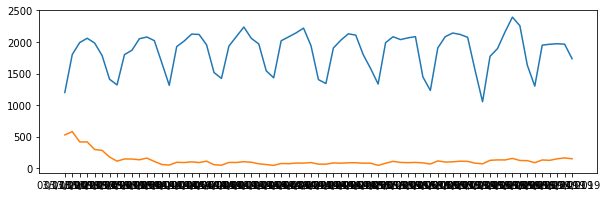

In [148]:
plt.figure(figsize=(10,3))
plt.plot(pre_dates,pre_counts)
plt.plot(pre_dates,post_counts[:69])

Challenge 5

In [195]:
pre_stations = pre_dailies.groupby(['station', 'date'])['day_count'].sum().reset_index()
pre_stations.tail()

,station,date,day_count
25990,ZEREGA AV,05/20/2019,2745.0
25991,ZEREGA AV,05/21/2019,2856.0
25992,ZEREGA AV,05/22/2019,2872.0
25993,ZEREGA AV,05/23/2019,2768.0
25994,ZEREGA AV,05/24/2019,2737.0


In [161]:
post_stations = post_dailies.groupby(['station', 'date'])['day_count'].sum().reset_index()

Challenge 6

In [190]:
from collections import defaultdict

In [209]:
pre_time_series = defaultdict(list)
for row in pre_stations.itertuples():
    pre_time_series[row[1]].append((row[2], row[3]))

In [198]:
post_time_series = defaultdict(list)
for row in post_stations.itertuples():
    post_time_series[row[1]].append((row[2], row[3]))

Challenge 7:

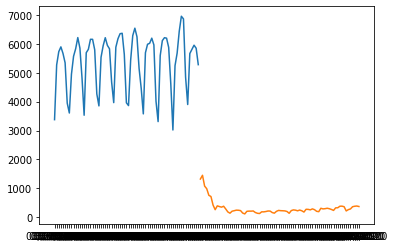

In [217]:
unzipped = list(zip(*pre_time_series['CLARK ST']))
dates = unzipped[0]
counts = unzipped[1]
plt.plot(dates, counts)
unz = list(zip(*post_time_series['CLARK ST']))
date = unz[0]
count = unz[1]
plt.plot(date, count)